# Garmin Running Data
> Exploring my Garmin data to become a better runner

- toc: false
- branch: master
- badges: false
- comments: false
- categories: [jupyter, fitness]
- image: images/some_folder/your_image.png
- hide: false
- search_exclude: false

I have a very simple data exercise I’d like to accomplish as I start my path towards becoming a Data Scientist. I want to take a look at my own data that I’ve collected with Garmin and see if I can pull any insights from it around my running habits and how I can become a more effective runner.

If I’m able to come to some conclusions, that could be an interesting case study for the value of data. At the very least, I’ll be putting a comedic foot forward by putting my own running statistics on display.

For the purpose of this data study, I’m trying to use what I have immediately available as I’m generally pretty familiar with describing datasets using tools such as Excel (via Pivot Tables), Tableau + SQL or, in a previous life, leveraging IDL & MATLAB. The concepts of exploring a dataset are common to me but right now I’m focused on learning the languages of R & Python.

This writing exercise, is focused on my conclusions. If you’re interested in my process of analysis and the basics of how shaped the data, collected it, and drawn these conclusions – let me know. I’ll be doing my best to explain any statistical concepts I’m using (since I’ll be learning those, too). 
 
I’m collecting my data directly from Garmin’s website – https://connect.garmin.com/modern/activities, filtering specifically for my running activities. Garmin allows you to export the data directly to .csv.

My goal with looking at this data is to understand the following:

- When was I the best runner?
- How can I become a better runner?

In [199]:
#hide

#main packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import time


#no idea what these are for
import seaborn as sns #importing seaborn module 
import warnings
warnings.filterwarnings('ignore')  #this will ignore the warnings.it wont display warnings in notebook
#plt.style.use('fivethirtyeight')
plt.style.use('ggplot')
plt.rcParams['figure.figsize']=[6,3]
plt.rcParams['figure.dpi']=80

# Understanding & Setting up the Data

### First things first, let's load the file.

In [200]:
#hide
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 15)
garmin_data = pd.read_csv("data/garmin-runs.csv")
data = garmin_data
data.sample(5)

,Activity Type,Date,Favorite,Title,Distance,Calories,Time,...,Bottom Time,Min Temp,Surface Interval,Decompression,Best Lap Time,Number of Laps,Max Temp
66,Running,2020-01-06 05:29:29,False,Santa Ana Running,1.13,147,00:12:03,...,0:00,0.0,0:00,No,00:00.00,1,0.0
165,Running,2018-08-07 06:54:57,False,Santa Ana Running,2.56,365,00:27:31,...,0:00,0.0,0:00,No,00:00.00,1,0.0
350,Running,2017-08-29 17:45:52,False,Running,2.54,377,00:27:26,...,0:00,0.0,0:00,No,00:00.00,--,0.0
147,Running,2019-03-24 12:01:15,False,Santa Ana Running,2.10,339,00:27:15,...,0:00,0.0,0:00,No,00:00.00,1,0.0
86,Running,2019-10-28 05:40:36,False,Santa Ana Running,0.80,94,00:08:19.1,...,0:00,0.0,0:00,No,00:00.00,1,0.0


In [201]:
data.isnull().sum()

Activity Type       0
Date                0
Favorite            0
Title               0
Distance            0
                   ..
Surface Interval    0
Decompression       0
Best Lap Time       0
Number of Laps      0
Max Temp            0
Length: 30, dtype: int64

In [202]:
# get basic info about dataframe & types
data.info()

#sample of data 
data.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369 entries, 0 to 368
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Activity Type             369 non-null    object 
 1   Date                      369 non-null    object 
 2   Favorite                  369 non-null    bool   
 3   Title                     369 non-null    object 
 4   Distance                  369 non-null    float64
 5   Calories                  369 non-null    object 
 6   Time                      369 non-null    object 
 7   Avg HR                    369 non-null    object 
 8   Max HR                    369 non-null    object 
 9   Aerobic TE                369 non-null    object 
 10  Avg Run Cadence           369 non-null    object 
 11  Max Run Cadence           369 non-null    object 
 12  Avg Pace                  369 non-null    object 
 13  Best Pace                 369 non-null    object 
 14  Elev Gain 

,Activity Type,Date,Favorite,Title,Distance,Calories,Time,...,Bottom Time,Min Temp,Surface Interval,Decompression,Best Lap Time,Number of Laps,Max Temp
204,Running,2018-05-30 07:07:01,False,Santa Ana Running,1.15,146,00:11:33,...,0:00,0.0,0:00,No,00:00.00,1,0.0
319,Running,2017-12-11 17:07:28,False,Running,2.06,254,00:22:28,...,0:00,0.0,0:00,No,00:00.00,1,0.0
120,Running,2019-09-08 09:53:05,False,Santa Ana Running,2.10,291,00:23:39,...,0:00,0.0,0:00,No,00:00.00,1,0.0
201,Running,2018-06-02 13:26:30,False,Santa Ana Running,2.08,298,00:22:59,...,0:00,0.0,0:00,No,00:00.00,1,0.0
254,Running,2018-03-28 07:19:40,False,Santa Ana Running,1.08,132,00:10:31,...,0:00,0.0,0:00,No,00:00.00,1,0.0


In [203]:
#function to remove "--"
def clean_na(val, pace=False):
    if pace == True:
        newval = val.replace("--", "99:99")
    else:
        newval = val.replace("--", '0').replace(',','')
    return str(newval)

def time_of_day(date):
    morn_start = dt.time(6,00)
    afternoon_start = dt.time(12,00)
    late_afternoon_start = dt.time(15,00)
    evening_start = dt.time(18,00)
    
    time_of_run = dt.datetime.time(date)
    
    if evening_start <= time_of_run < morn_start:
        return "Evening"
    elif morn_start <= time_of_run < afternoon_start:
        return "Morning"
    elif afternoon_start <= time_of_run < late_afternoon_start:
        return "Afternoon"
    elif late_afternoon_start <= time_of_run < evening_start:
        return "Late Afternoon"


#adjust column names
data.rename(columns = {'Time' : 'Minutes Elapsed'}, inplace= True)


#fix data types
data['Date'] = data['Date'].astype('datetime64')
data['Day of Week'] = data['Date'].dt.day_name()
data['Year'] = data['Date'].apply(lambda x: x.year)
data['Month'] = data['Date'].apply(lambda x: x.month)
data['Favorite'] = data['Favorite'].astype('bool')
data['Calories'] = data['Calories'].str.replace(',','')
data['Calories'] = data['Calories'].apply(clean_na).astype(int)
    #converting my total elapsed time to minutes, rounding.
data['Minutes Elapsed'] = data['Minutes Elapsed'].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]) + round(float(x[2])/60,1))
data['Avg HR'] = data['Avg HR'].apply(clean_na).astype(int)
data['Max HR'] = data['Max HR'].apply(clean_na).astype(int)
data['Aerobic TE'] = data['Aerobic TE'].apply(clean_na).astype(float)
data['Avg Run Cadence'] = data['Avg Run Cadence'].apply(clean_na).astype(int)
data['Max Run Cadence'] = data['Max Run Cadence'].apply(clean_na).astype(int)
    #convert pace to mph
data['Avg Pace'] = data['Avg Pace'].apply(clean_na, pace=True).str.split(':').apply(lambda x: 60/(int(x[0]) +  int(x[1])/60))
data['Best Pace'] = data['Best Pace'].apply(clean_na, pace=True).str.split(':').apply(lambda x: 60/(int(x[0]) +  int(x[1])/60))
data['Elev Gain'] = data['Elev Gain'].apply(clean_na).astype(int)
data['Elev Loss'] = data['Elev Loss'].apply(clean_na).astype(int)
data['Climb Time'] = data['Climb Time'].str.split(':').apply(lambda x: int(x[0]) + float(x[1])/60)
data['Time of Day'] = data['Date'].apply(time_of_day)
data = data.drop(columns=['Favorite', 'Avg Vertical Ratio', 'Avg Vertical Oscillation', 'Training Stress Score®', 'Grit', 'Flow','Bottom Time', 'Min Temp', 'Surface Interval', 'Decompression', 'Best Lap Time', 'Number of Laps', 'Max Temp'])

data.info()
data.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369 entries, 0 to 368
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Activity Type      369 non-null    object        
 1   Date               369 non-null    datetime64[ns]
 2   Title              369 non-null    object        
 3   Distance           369 non-null    float64       
 4   Calories           369 non-null    int64         
 5   Minutes Elapsed    369 non-null    float64       
 6   Avg HR             369 non-null    int64         
 7   Max HR             369 non-null    int64         
 8   Aerobic TE         369 non-null    float64       
 9   Avg Run Cadence    369 non-null    int64         
 10  Max Run Cadence    369 non-null    int64         
 11  Avg Pace           369 non-null    float64       
 12  Best Pace          369 non-null    float64       
 13  Elev Gain          369 non-null    int64         
 14  Elev Loss 

,Activity Type,Date,Title,Distance,Calories,Minutes Elapsed,Avg HR,...,Elev Loss,Avg Stride Length,Climb Time,Day of Week,Year,Month,Time of Day
115,Running,2019-09-16 05:28:42,Santa Ana Running,2.07,282,22.9,151,...,10,0.87,22.900000,Monday,2019,9,None
0,Running,2020-11-15 06:50:57,Anaheim - Long Easy Run,4.65,630,50.0,151,...,66,0.97,50.033333,Sunday,2020,11,Morning
108,Running,2019-10-01 05:32:39,Santa Ana Running,2.09,290,23.6,149,...,7,0.87,23.566667,Tuesday,2019,10,None
232,Running,2018-04-20 07:10:10,Santa Ana Running,1.16,143,11.0,146,...,10,1.01,11.033333,Friday,2018,4,Morning
294,Running,2018-02-14 07:04:26,Santa Ana Running,2.10,246,19.6,154,...,7,1.06,19.633333,Wednesday,2018,2,Morning


In [204]:
data.describe()

,Distance,Calories,Minutes Elapsed,Avg HR,Max HR,Aerobic TE,Avg Run Cadence,...,Best Pace,Elev Gain,Elev Loss,Avg Stride Length,Climb Time,Year,Month
count,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,...,369.000000,369.000000,369.00000,369.000000,369.000000,369.000000,369.000000
mean,2.470244,331.208672,27.203794,140.086721,155.108401,1.947696,138.902439,...,8.396128,27.094851,29.96206,0.783848,24.057037,2018.441734,6.875339
std,1.265270,174.437566,15.208155,37.266127,41.480930,1.375366,57.342708,...,5.589009,80.188089,93.31360,0.331930,11.926579,0.959786,3.058428
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.596125,0.000000,0.00000,0.000000,0.040000,2017.000000,1.000000
25%,1.820000,240.000000,19.200000,145.000000,158.000000,0.000000,154.000000,...,6.326889,5.000000,7.00000,0.850000,14.550000,2018.000000,4.000000
50%,2.090000,285.000000,23.000000,149.000000,165.000000,2.400000,164.000000,...,6.716418,10.000000,11.00000,0.900000,22.566667,2018.000000,8.000000
75%,3.170000,416.000000,34.100000,154.000000,171.000000,3.000000,166.000000,...,7.578947,16.000000,16.00000,0.950000,28.916667,2019.000000,9.000000
max,9.450000,1135.000000,136.600000,173.000000,196.000000,4.500000,170.000000,...,54.545455,787.000000,1278.00000,1.150000,58.366667,2020.000000,12.000000


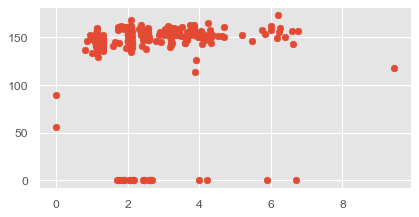

In [205]:
plt.scatter(data['Distance'], data['Avg HR'])

In [206]:
pd.crosstab(round(data['Distance'],0), data['Avg HR']).style.background_gradient(cmap='summer_r')

Avg HR,0,56,90,114,118,126,129,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,165,168,173
Distance,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1.0,0,0,0,0,0,0,1,2,1,1,2,2,3,1,5,2,6,9,8,10,6,8,3,3,2,1,2,0,2,0,0,0,1,1,0,0,0,0,0,0
2.0,14,0,0,0,0,0,0,0,1,0,0,1,3,2,3,3,2,5,10,9,9,5,9,12,6,6,6,13,3,5,5,6,4,2,7,3,1,0,1,0
3.0,5,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,2,1,1,4,0,4,6,6,3,3,2,3,3,2,2,4,5,0,1,0,0,0,0
4.0,2,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,3,0,0,3,2,0,7,7,5,3,0,2,2,2,1,1,0,3,0,2,1,0,0
5.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,2,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
6.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,2,0,1,0,1,0,0,0,1
7.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
9.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


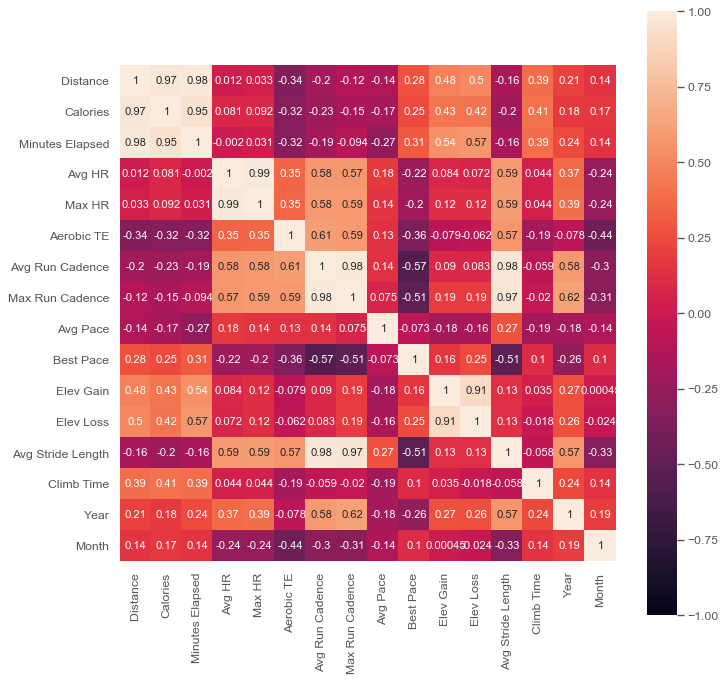

In [207]:
#what is a correlation matrix?
corrmat = data.corr()
fig = plt.figure(figsize = (10,10))
sns.heatmap(corrmat,vmax = 1,square = True,annot = True,vmin = -1)
plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369 entries, 0 to 368
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Activity Type      369 non-null    object        
 1   Date               369 non-null    datetime64[ns]
 2   Title              369 non-null    object        
 3   Distance           369 non-null    float64       
 4   Calories           369 non-null    int64         
 5   Minutes Elapsed    369 non-null    float64       
 6   Avg HR             369 non-null    int64         
 7   Max HR             369 non-null    int64         
 8   Aerobic TE         369 non-null    float64       
 9   Avg Run Cadence    369 non-null    int64         
 10  Max Run Cadence    369 non-null    int64         
 11  Avg Pace           369 non-null    float64       
 12  Best Pace          369 non-null    float64       
 13  Elev Gain          369 non-null    int64         
 14  Elev Loss 

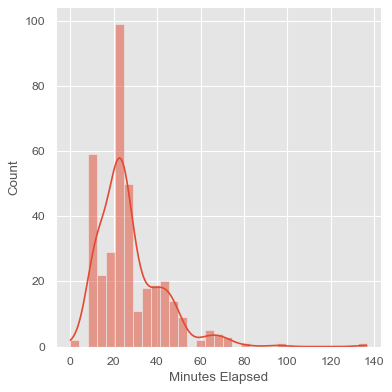

In [208]:
sns.displot(data['Minutes Elapsed'], kde=True)
data.info()

# Potential Questions to Ask

## Which day & time am I the fastest?

## Am I most effective in the morning or afternoon?

## How many calories to I burn per minute, while running?

## If I were to continue my trend of faster pace, when could I run a 7 minute mile?

## What is the relationship between weekly mileage and weekly pace change?



NameError: name 'plot' is not defined

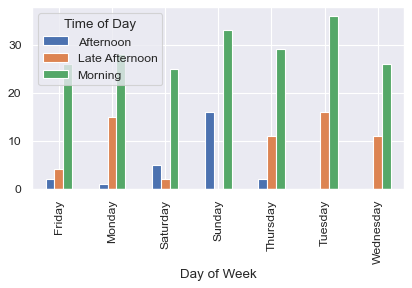

In [209]:

sns.set()
data.pivot_table('Title', index="Day of Week", columns="Time of Day", aggfunc='count').plot.bar()
data.pivot_table('Title', index="Year", columns="Day of Week", aggfunc='count')
plot.sc
### Which day do I run the most?

#data.pivot_table('Avg Pace', index=data['Year'], columns="Time of Day", aggfunc='mean')

In [ ]:
#Examining Habits
fig, ax = plt.subplots()
ax.plot_date(data['Date'], data['Avg Pace'])
fig.autofmt_xdate()

#3 main periods of running recorded in Garmin. 
# 7/2017 - 11/2018
period_1 = [datetime.date(2017, 7,1), datetime.date(2018,10,13)]
# ax.set_xlim([datetime.date(2017, 7,1), datetime.date(2018,11,1)])
# 7/2019 - 12/2019
period_2 = [datetime.date(2019, 7,1), datetime.date(2019,12,1)]
# ax.set_xlim([datetime.date(2019, 7,1), datetime.date(2019,12,1)])
# 1/2020 - 12/2020
period_3 = [datetime.date(2020, 8,1), dt.datetime.now()]
#ax.set_xlim([datetime.date(2020, 8,1), datetime.date(2020,11,1)])


ax.set_xlim(period_3)

In [ ]:
data.pivot_table('Title', index="Year", columns = 'Month', aggfunc='count', fill_value=0)

In [ ]:
data.pivot_table('Distance', index="Year", columns = 'Month', aggfunc='sum', fill_value=0)

In [ ]:
data.pivot_table('Avg Pace', index="Year", columns = 'Month', aggfunc='mean', fill_value=0)